In [ ]:
!pip install textstat
import numpy as np
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from statistics import *
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import textstat

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium 
from folium import plugins 



def plot_readability(a,b,title,bins=0.1,colors=['#3A4750', '#F64E8B']):
    trace1 = ff.create_distplot([a,b], [" Real disaster tweets","Not real disaster tweets"], bin_size=bins, colors=colors, show_rug=False)
    trace1['layout'].update(title=title)
    py.iplot(trace1, filename='Distplot')
    table_data= [["Statistical Measures"," Not real disaster tweets","real disaster tweets"],
                ["Mean",mean(a),mean(b)],
                ["Standard Deviation",pstdev(a),pstdev(b)],
                ["Variance",pvariance(a),pvariance(b)],
                ["Median",median(a),median(b)],
                ["Maximum value",max(a),max(b)],
                ["Minimum value",min(a),min(b)]]
    trace2 = ff.create_table(table_data)
    py.iplot(trace2, filename='Table')

punctuations = string.punctuation
stopwords = list(STOP_WORDS)

parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

import re
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def removeurl(raw_text):
    clean_text = re.sub(r'^https?:\/\/.*[\r\n]*', '', raw_text, flags=re.MULTILINE)
    return clean_text

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sub = pd.read_csv('./sample_submission.csv')

In [ ]:

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:

test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:

train['text'] = train['text'].apply(lambda x:cleanhtml(x))
test['text'] = test['text'].apply(lambda x:cleanhtml(x))


train['text'] = train['text'].apply(lambda x:removeurl(x))
test['text'] = test['text'].apply(lambda x:removeurl(x))


In [ ]:
cnt_srs = train['target'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Jet',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")


labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")
fig.show(renderer='colab')

In [ ]:
cnt_ = train['location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
trace1 = go.Bar(
                x = cnt_.index,
                y = cnt_.values,
                name = "Number of tweets in dataset according to location",
                marker = dict(color = 'rgba(200, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )

data = [trace1]
layout = go.Layout(barmode = "group",title = 'Number of tweets in dataset according to location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)
fig.show(renderer='colab')

In [ ]:
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]
cnt_1 = train1_df['location'].value_counts()
cnt_1.reset_index()
cnt_1 = cnt_1[:20,]

cnt_0 = train0_df['location'].value_counts()
cnt_0.reset_index()
cnt_0 = cnt_0[:20,]

trace1 = go.Bar(
                x = cnt_1.index,
                y = cnt_1.values,
                name = "Number of tweets about real disaster location wise",
                marker = dict(color = 'rgba(255, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
trace0 = go.Bar(
                x = cnt_0.index,
                y = cnt_0.values,
                name = "Number of tweets other than real disaster location wise",
                marker = dict(color = 'rgba(79, 82, 97, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets in dataset according to location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)
fig.show(renderer='colab')

In [ ]:
df = train['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="specify_your_app_name_here")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

USA
New York
United States
London
Canada
Nigeria
UK
Los Angeles, CA
India
Mumbai
Washington, DC
Kenya
Worldwide
Australia
Chicago, IL
California
Everywhere
New York, NY
California, USA
Florida


In [ ]:
map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

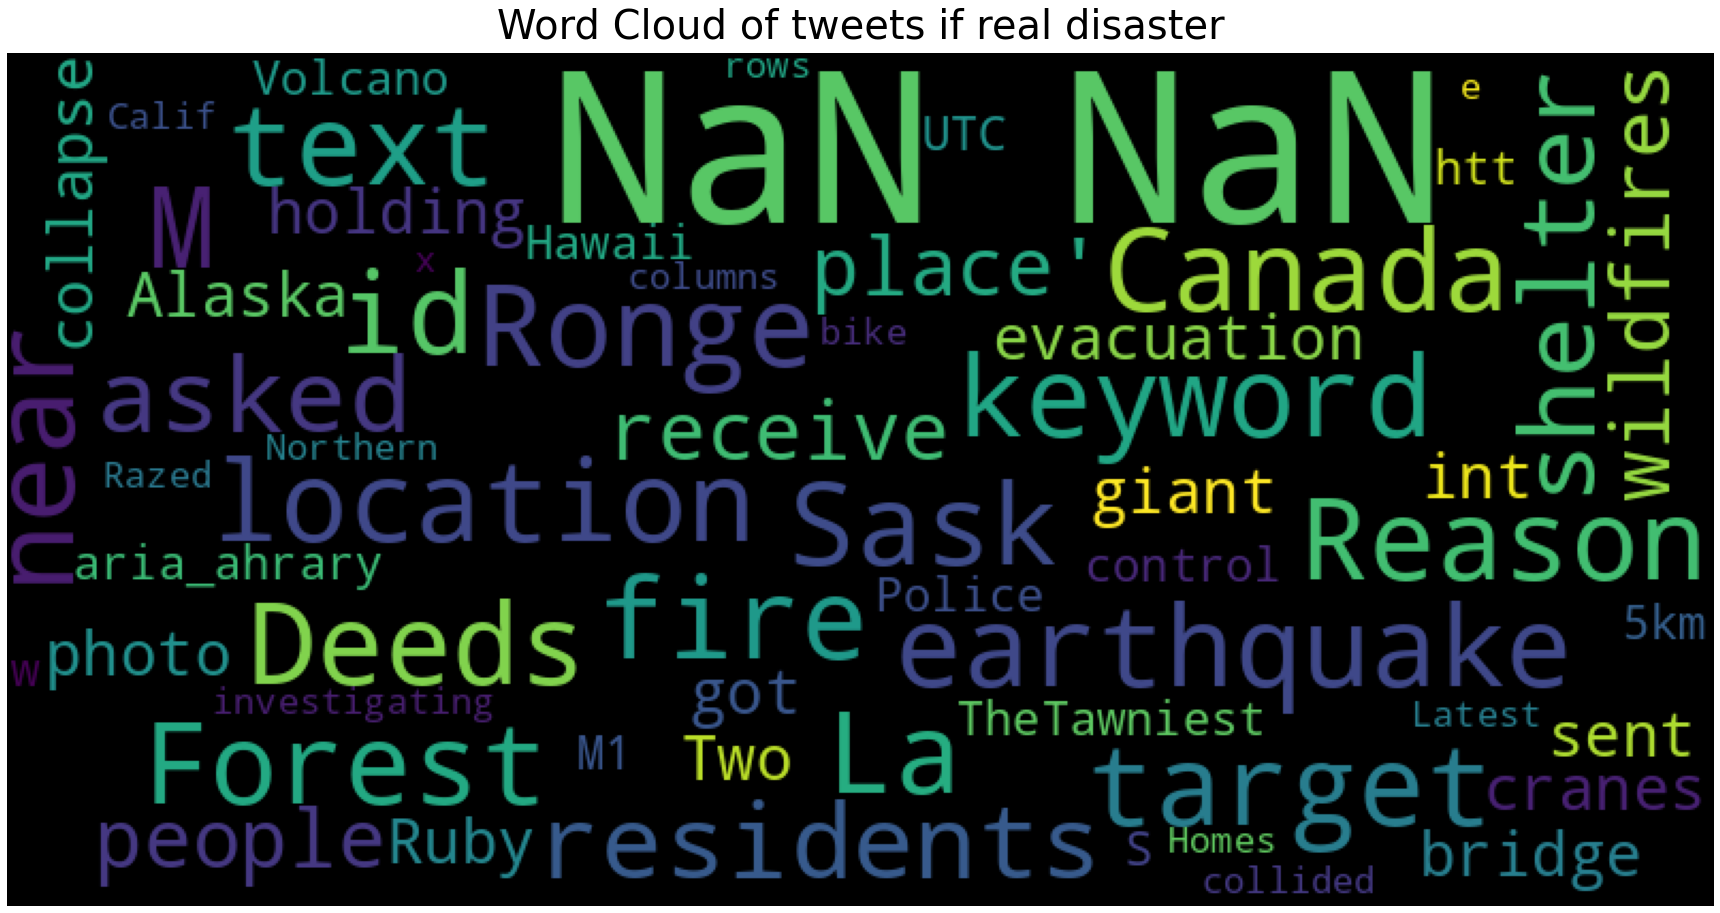

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train[train["target"]==1], title="Word Cloud of tweets if real disaster")

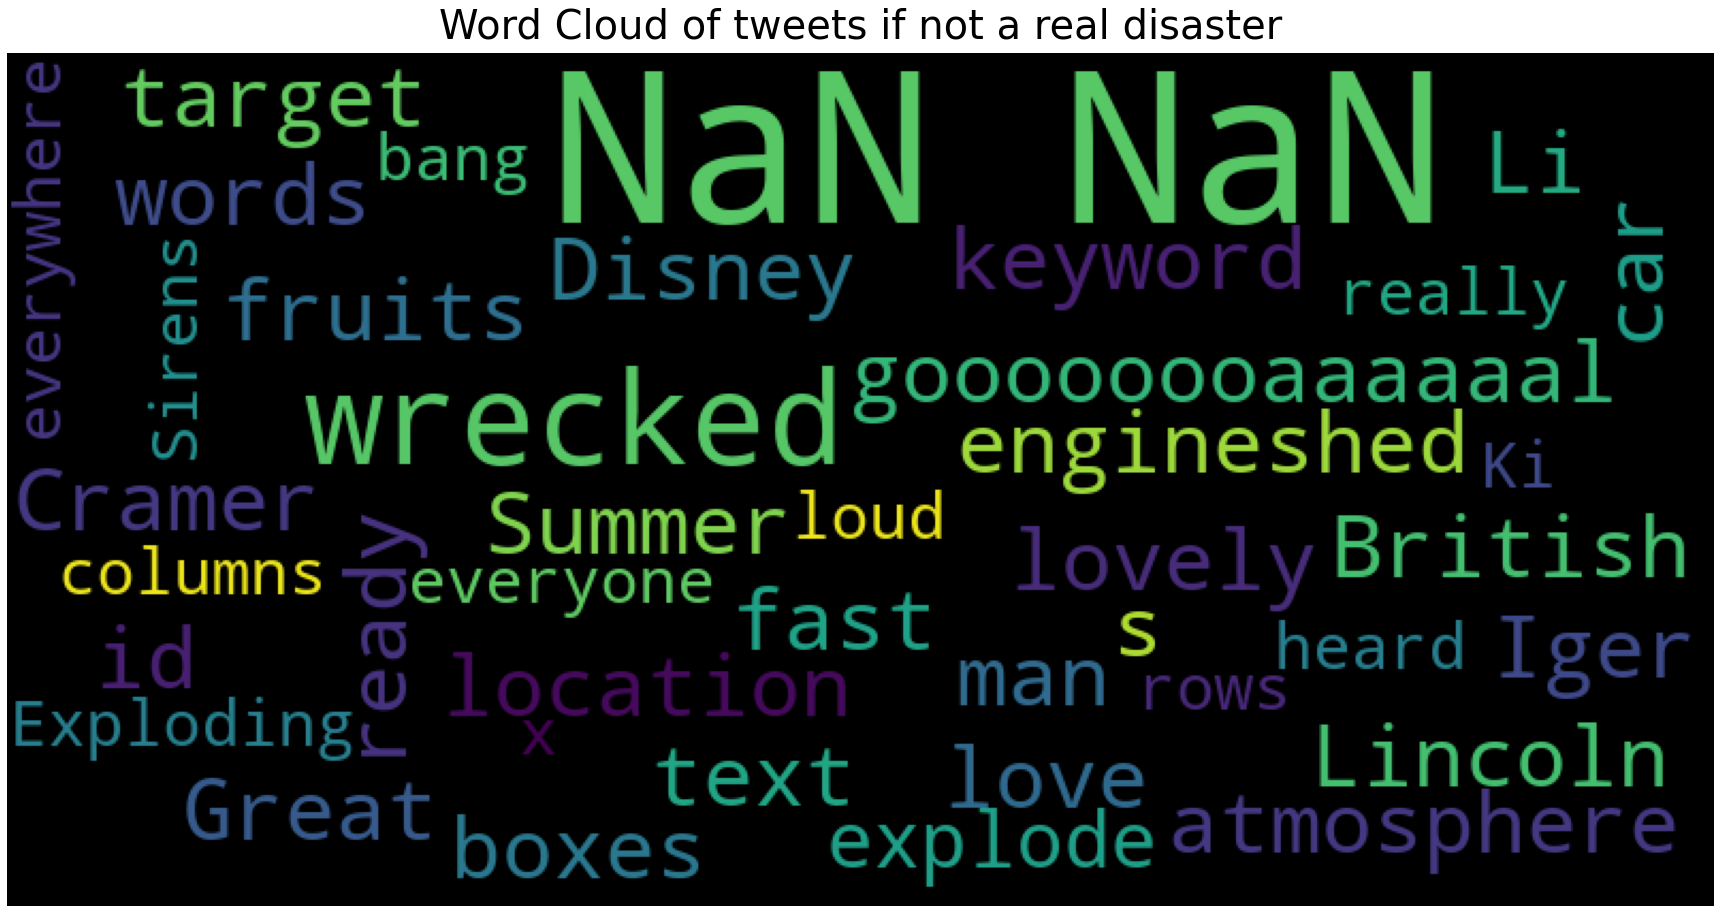

In [ ]:
plot_wordcloud(train[train["target"]==0], title="Word Cloud of tweets if not a real disaster")

In [ ]:
from collections import defaultdict
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]


def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]


def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace


freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'red')


freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'red')


fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words if tweet is not real disaster", 
                                          "Frequent words if tweet is real disaster"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')
fig.show(renderer='colab')


In [ ]:
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')


fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent words if tweet is not real disaster", 
                                          "Frequent words if tweet is real disaster"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')
fig.show(renderer='colab')

In [ ]:
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent words if tweet is not real disaster", 
                                          "Frequent words if tweet is real disaster"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')
fig.show(renderer='colab')

In [ ]:
train["num_words"] = train["text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["text"].apply(lambda x: len(str(x).split()))


train["num_unique_words"] = train["text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["text"].apply(lambda x: len(set(str(x).split())))


train["num_chars"] = train["text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["text"].apply(lambda x: len(str(x)))


train["num_stopwords"] = train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test["num_stopwords"] = test["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))


train["num_punctuations"] =train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] =test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )


train["num_words_upper"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

train["num_words_title"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))


train["mean_word_len"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

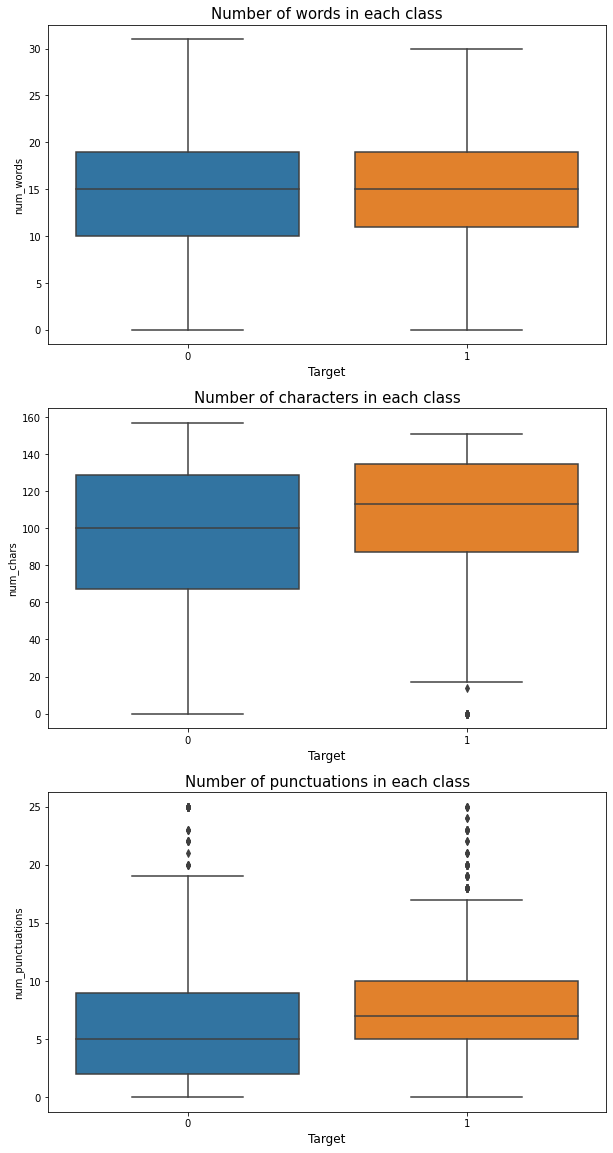

In [ ]:
train['num_words'].loc[train['num_words']>60] = 100 #truncation for better visuals
train['num_punctuations'].loc[train['num_punctuations']>25] = 25 #truncation for better visuals
train['num_chars'].loc[train['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='target', y='num_words', data=train, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='target', y='num_chars', data=train, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='target', y='num_punctuations', data=train, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

In [ ]:
tqdm.pandas()

In [ ]:
notreal_text = train['text'][train['target'] == 0]
real_text = train["text"][train["target"] == 1]
vectorizer_notreal = CountVectorizer(min_df=5, max_df=0.9, stop_words="english", lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
notreal_vectorized = vectorizer_notreal.fit_transform(notreal_text)
vectorizer_real = CountVectorizer(min_df=5, max_df=0.9, stop_words="english", lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
real_vectorized = vectorizer_real.fit_transform(real_text)

In [ ]:

lda_notreal = LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online',verbose=True)
notreal_lda = lda_notreal.fit_transform(notreal_vectorized)
lda_real = LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online',verbose=True)
real_lda = lda_real.fit_transform(real_vectorized)

iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


In [ ]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [ ]:
print("Not real disaster tweets LDA Model:")
selected_topics(lda_notreal, vectorizer_notreal)

Not real disaster tweets LDA Model:
Topic 0:
[('http', 215.43579904838964), ('https', 187.8032377618258), ('smoke', 45.44095458889825), ('harm', 37.318568258423184), ('check', 34.80836577008705), ('lot', 31.12804208327394), ('long', 30.89498072801662), ('said', 30.791764515016236), ('run', 29.230038155477665), ('sirens', 27.16820219650574)]
Topic 1:
[('don', 141.44345030593684), ('got', 84.24408917487133), ('good', 70.3714487898333), ('just', 69.55898435568177), ('make', 56.74651604915605), ('content', 52.72453072623068), ('shit', 34.128148255473214), ('fuck', 33.40959702369874), ('hope', 31.581916011268273), ('song', 30.948886946467997)]
Topic 2:
[('people', 96.45130733833014), ('like', 93.16175153831848), ('let', 77.34416732081047), ('god', 48.82429094357064), ('look', 45.158419654098545), ('year', 37.62390844362968), ('movie', 35.320713711331514), ('nuclear', 34.65619462880382), ('work', 34.213517082582904), ('better', 34.16710663889991)]
Topic 3:
[('http', 1368.2850903719198), ('ne

In [ ]:
print("Real disaster tweets LDA Model:")
selected_topics(lda_real, vectorizer_real)

Real disaster tweets LDA Model:
Topic 0:
[('http', 220.47265957235047), ('california', 122.06381590495562), ('news', 108.8999207055352), ('fires', 88.28944464026556), ('wildfire', 81.01479802697519), ('northern', 70.36778478776571), ('legionnaires', 66.34462620770444), ('outbreak', 43.44548623651214), ('don', 37.08717174844421), ('affected', 35.11645173523002)]
Topic 1:
[('http', 153.64091412293484), ('latest', 50.72357364238847), ('mass', 48.811861532215964), ('news', 42.46377785736346), ('suspect', 39.42607083680354), ('train', 34.39660845463868), ('says', 31.528459630105367), ('caused', 27.313636943152613), ('isis', 27.069398266058094), ('going', 25.972270238568505)]
Topic 2:
[('http', 157.86985050200389), ('confirmed', 88.73608746954882), ('investigators', 70.4425400818069), ('homes', 60.38058017046192), ('conclusively', 50.30447499928595), ('wounded', 46.50830510472843), ('collapse', 41.363687256696366), ('state', 40.730036448749395), ('rescuers', 38.53025685701651), ('missing', 3

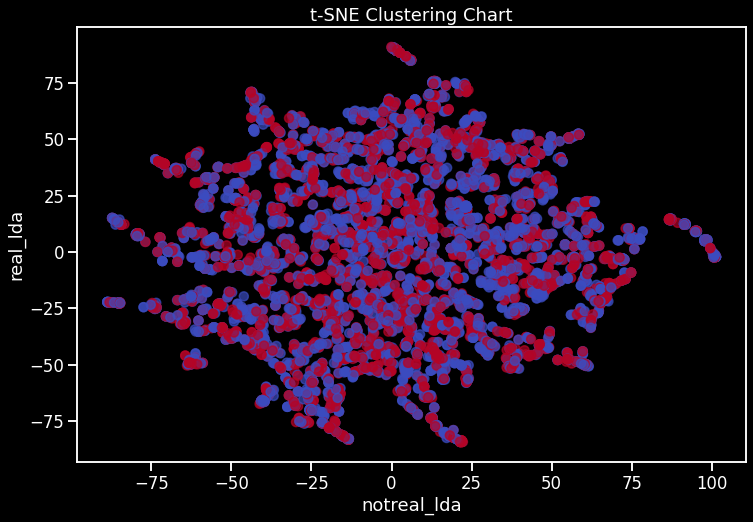

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


all_lda = np.concatenate((notreal_lda, real_lda))


tsne = TSNE(n_components=2, random_state=0)

tsne_lda = tsne.fit_transform(all_lda)


plt.figure(figsize=(12,8))
plt.scatter(tsne_lda[:,0], tsne_lda[:,1], c=train['target'], cmap='coolwarm', alpha=0.7)
plt.xlabel('notreal_lda')
plt.ylabel('real_lda')
plt.title('t-SNE Clustering Chart')
plt.show()

In [ ]:
import plotly.express as px
from sklearn.manifold import TSNE


lda_results = np.concatenate((notreal_lda, real_lda))


tsne_model = TSNE(n_components=3, perplexity=50, learning_rate=200, n_iter=1000, verbose=1, random_state=42)
tsne_lda = tsne_model.fit_transform(lda_results)

color_array = np.array(["red"]*len(notreal_lda) + ["blue"]*len(real_lda))


tsne_df = pd.DataFrame(tsne_lda, columns=["tsne1", "tsne2", "tsne3"])
tsne_df["target"] = color_array


fig = px.scatter_3d(tsne_df, x="tsne1", y="tsne2", z="tsne3", color="target")
fig.show(renderer='colab')

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7613 samples in 0.028s...
[t-SNE] Computed neighbors for 7613 samples in 2.400s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7613
[t-SNE] Computed conditional probabilities for sample 2000 / 7613
[t-SNE] Computed conditional probabilities for sample 3000 / 7613
[t-SNE] Computed conditional probabilities for sample 4000 / 7613
[t-SNE] Computed conditional probabilities for sample 5000 / 7613
[t-SNE] Computed conditional probabilities for sample 6000 / 7613
[t-SNE] Computed conditional probabilities for sample 7000 / 7613
[t-SNE] Computed conditional probabilities for sample 7613 / 7613
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.839088
[t-SNE] KL divergence after 1000 iterations: 1.064691


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 KB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=d075c21508a295bd3def56f9bc1a717682fa9c3588098d9a7580dcb275024982
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=8f145f5ef6d2bbccca536043e01fc4c9e1f77d03332b1863b955d30c44ddeb50
  Stored in directory: /root/.cac

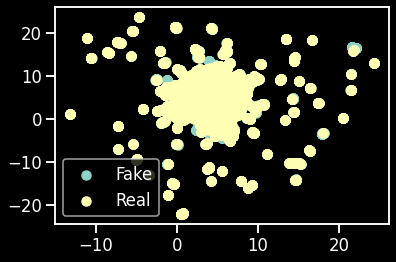

In [ ]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel
import umap

# Combine the LDA topic distributions of fake and real news into a single array
topic_distributions = np.concatenate((notreal_lda, real_lda), axis=0)

# Reduce the dimensionality of the topic distributions using UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(topic_distributions)

# Plot the UMAP embeddings
import matplotlib.pyplot as plt

plt.scatter(umap_embeddings[:len(notreal_lda), 0], umap_embeddings[:len(notreal_lda), 1], label='Fake')
plt.scatter(umap_embeddings[len(notreal_lda):, 0], umap_embeddings[len(notreal_lda):, 1], label='Real')
plt.legend()
plt.show(renderer='colab')


